<a href="https://colab.research.google.com/github/rsidorchuk93/object_face_detection/blob/main/objects_and_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object and face detection

In [1]:
# connecting to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing required libraries - object detection (based on transformers) and face recognition**

In [2]:
pip install face_recognition -q

In [3]:
pip install deepface -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.5 MB/s eta 0:00:00


In [4]:
pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.0 MB/s eta 0:00:00


In [5]:
pip install torch -q

In [6]:
pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 32.4 MB/s eta 0:00:00


## Object detection

In [7]:
# Import libraries and initiating processor and model
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


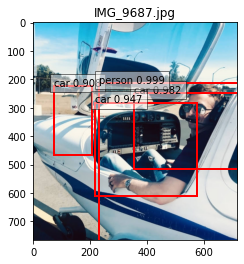

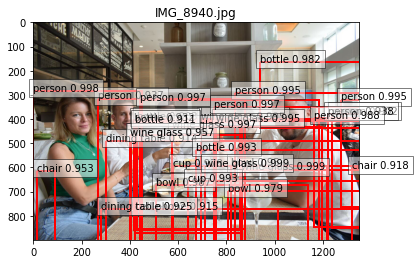

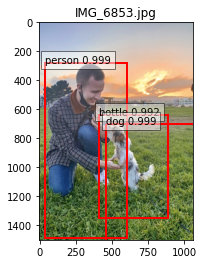

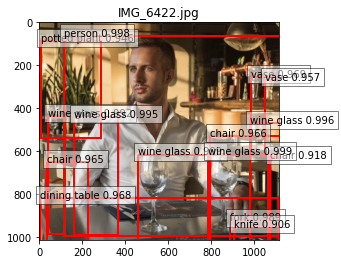

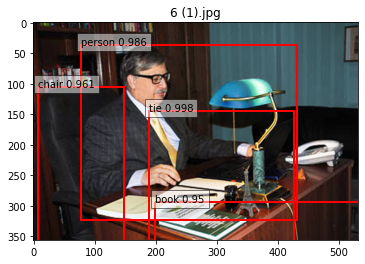

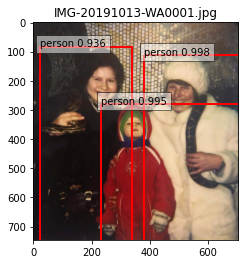

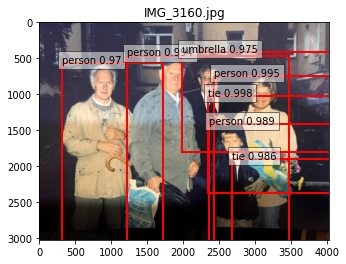

In [10]:
# Load and process images
photo_dir = '/content/drive/My Drive/test/photo_object_face_detection'
output_dir = os.path.join(photo_dir, 'persons')
os.makedirs(output_dir, exist_ok=True)

images = {}
for filename in os.listdir(photo_dir):
    if filename.endswith('.jpg'):
        filepath = os.path.join(photo_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

# Process and display each image
for image_name, image in images.items():
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Find the largest detected person
    largest_person = None
    largest_area = 0

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == "person":
            x, y, width, height = [round(i, 2) for i in box.tolist()]
            area = width * height

            if area > largest_area:
                largest_area = area
                largest_person = box

    # Save the cropped image of the largest person to the "persons" subfolder
    if largest_person is not None:
        x, y, width, height = [round(i, 2) for i in largest_person.tolist()]
        cropped_image = image.crop((x, y, x + width, y + height))
        cropped_image.save(os.path.join(output_dir, f"person_{image_name}"))

    # Display the original image with bounding boxes, confidence scores, and object names
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(image_name)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_str = model.config.id2label[label.item()]
        confidence = round(score.item(), 3)
        x, y, width, height = [round(i, 2) for i in box.tolist()]

        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y, f"{label_str} {confidence}", bbox=dict(facecolor="white", alpha=0.5))

    plt.show()

Out of the box transformer object detection model correctly detects people and some additional objects - animals, books, etc. As a next step, we'll crop persons and use face detection library to detect person's faces

## Face recognition

In [11]:
# import required libraries
import cv2
import numpy as np
import face_recognition

In [12]:
# define necessary functions
def detect_faces(image):
    image_np = np.array(image)
    image_np_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(image_np_rgb)
    face_images = []

    for (top, right, bottom, left) in face_locations:
        face_image = image_np[top:bottom, left:right]
        face_images.append(face_image)

    return face_locations, face_images

def draw_boundaries(image_np, face_locations, boundary_thickness=4):
    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(image_np, (left, top), (right, bottom), (0, 0, 255), boundary_thickness)
    return Image.fromarray(image_np)

def save_largest_face(faces, name_prefix, save_dir):
    if not faces:
        return

    largest_face = max(faces, key=lambda face: face.shape[0] * face.shape[1])
    filepath = os.path.join(save_dir, f"{name_prefix}_largest_face.png")
    cv2.imwrite(filepath, cv2.cvtColor(largest_face, cv2.COLOR_RGB2BGR))

def face_percentage(face, image):
    face_size = face.shape[0] * face.shape[1]
    image_size = image.shape[0] * image.shape[1]
    return (face_size / image_size) * 100

Image: person_IMG_9687.jpg
Face 1 size: 3.76% of the image


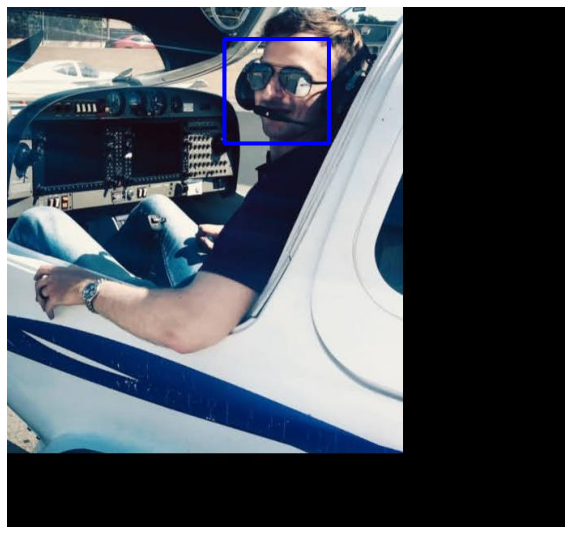

Image: person_IMG_8940.jpg
Face 1 size: 1.98% of the image
Face 2 size: 0.44% of the image


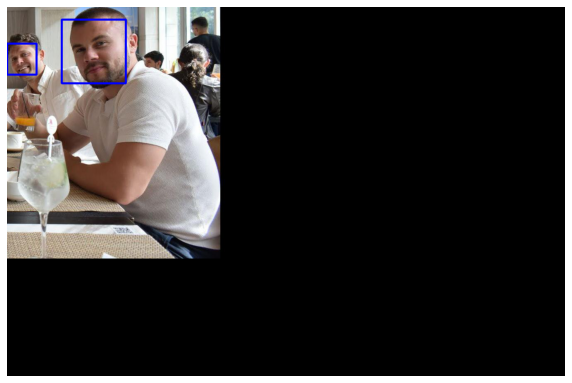

Image: person_IMG_6853.jpg


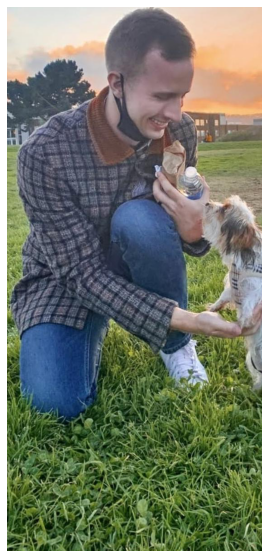

Image: person_IMG_6422.jpg
Face 1 size: 2.43% of the image


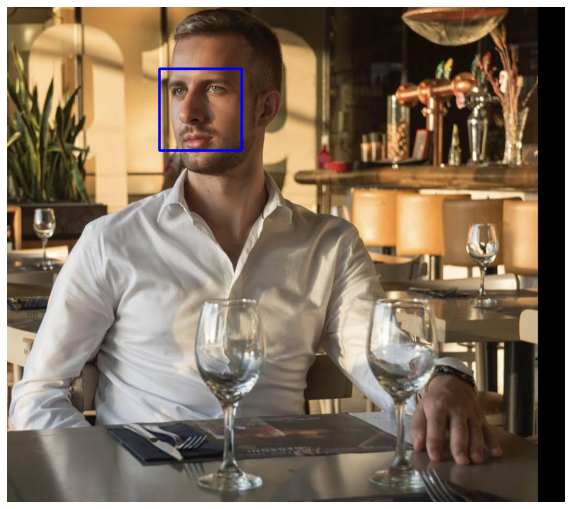

Image: person_6 (1).jpg
Face 1 size: 3.87% of the image


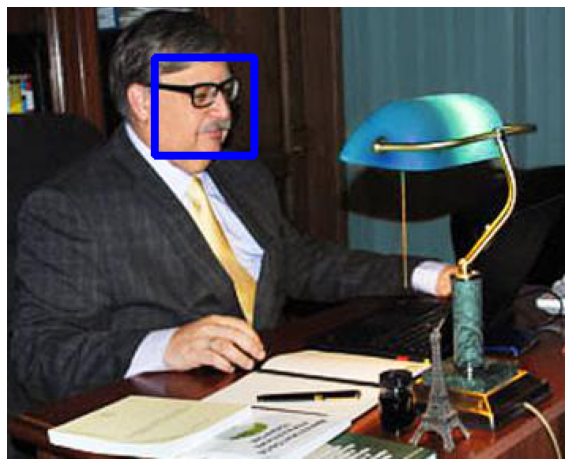

Image: person_IMG-20191013-WA0001.jpg


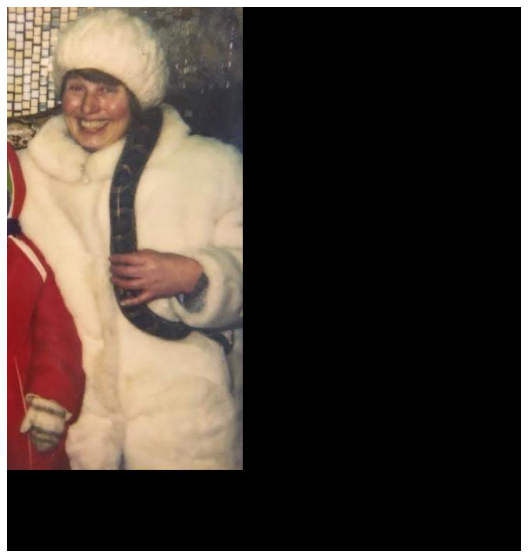

Image: person_IMG_3160.jpg
Face 1 size: 0.69% of the image
Face 2 size: 0.69% of the image


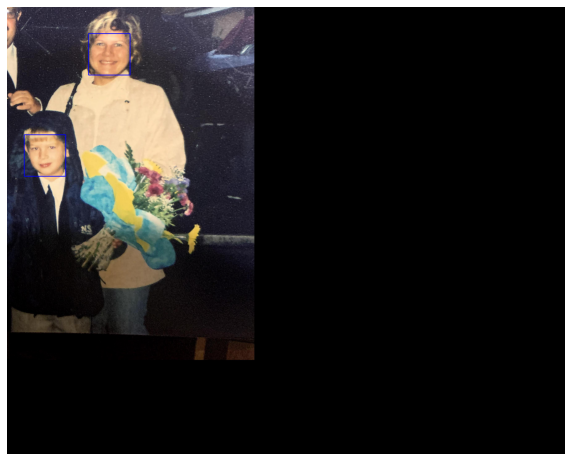

In [13]:
# Load and process images
photo_dir = '/content/drive/My Drive/test/photo_object_face_detection/persons'
images = {}
for filename in os.listdir(photo_dir):
    if filename.endswith('.jpg'):
        filepath = os.path.join(photo_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

# Create the "faces" subfolder if it doesn't exist
faces_dir = os.path.join(photo_dir, "faces")
if not os.path.exists(faces_dir):
    os.makedirs(faces_dir)

# Process and display images
for name, image in images.items():
    # Detect faces and obtain face images
    face_locations, face_images = detect_faces(image)

    # Save the largest face in the "faces" subfolder
    save_largest_face(face_images, name.split('.')[0], faces_dir)

    # Draw red and thick boundaries and display the image
    image_np = np.array(image)
    processed_image = draw_boundaries(image_np, face_locations, boundary_thickness=4)

    # Print the results
    print(f'Image: {name}')
    for idx, face_image in enumerate(face_images):
        face_percent = face_percentage(face_image, image_np)
        print(f'Face {idx + 1} size: {face_percent:.2f}% of the image')
    plt.figure(figsize=(10, 10))  # Set a custom figure size for larger images
    plt.imshow(processed_image)
    plt.axis('off')
    plt.show()